In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import xarray as xr
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
import vector_tools as vt
import khFunctions as khf

import matplotlib.patches as mpatches
from physoce import tseries as ts 
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from datetime import timedelta

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Spectral analysis and turbulent dissipation estimates

### Additional quality control for turbulent dissipation
- Additional QC of adv data is used to flag data runs (bursts of data) that have gaps of high correlation and signal strength (SNR)
- Parameters for dissipation QC are used from Fedderson, 2010 ("Quality controlling surf zone acoustic Doppler velocimeter observations to estimate the turbulent dissipation rate")
    - SNR on each beam should be > 15dB
    - CORR on each beam should be above .3 + .4(SQRT(f_s/f_max)), where f_s is the instrument sampling frequency, and f_max is the maximum sampling frequency the instrument is capable of 
    - Fraction of "bad data" to good data for each run is determined as sigmaSS and sigmaCORR
        - sigmaSS <= .1 (34560/38400 data points, or two minutes of "bad data" allowed)
        - sigmaCORR <= .7 (11520/38400 data points, or 14 minutes of "bad data" allowed)
    - Bad data runs that do not meet these criteria are discarded, and the remaining good data runs are "fixed"
        - Gaps in data <= 1s long are linearly interpolated between the good data points bounding the gap
        - Longer gaps are averaged and the entire gap is set to the averaged value
        - If the gap is significantly longer than a couple seconds, "patching" may be used
        - Patching removes the larger gaps in data and joins the good data points together, but may cause bias via time shifting in the frequency spectra

In [ ]:
### OBSOLETE FUNCTIONS ###
### SAVING JUST IN CASE

# Open up raw data (deployment and retreival data already removed)
adv1 = xr.open_dataset('ADV/adv1_dat.nc')
adv2 = xr.open_dataset('ADV/adv2_dat.nc')

snr_cutoff = 10 # 10 dB
corr_cutoff = .3 + (.4*np.sqrt(32/64)) # ~ 58% correlation
nmax = 38400 # Max number of samples in a single burst
fs = 32 # Sample frequency of the dataset

#e1_16hz = e_filter(adv1_16hz, SNR_cutoff, Corr_cutoff, , n_16, fs_16)
e1_qc = vt.eps_data_prep(adv1, snr_cutoff, corr_cutoff, nmax, fs)
e1_qc.to_netcdf('ADV/e1_qc.nc')

#e2_16hz = e_filter(adv2_16hz, SNR_cutoff, Corr_cutoff, n_16, fs_16)
e2_qc = vt.eps_data_prep(adv2, snr_cutoff, corr_cutoff, nmax, fs)
e2_qc.to_netcdf('ADV/e2_qc.nc')

### Estimating dissipation
- Using quality controlled adv data, turbulent dissipation (eps) can be estimated through velocity spectra
- Steps to estimate dissipation:
    - Determine proper detrend window and segment size for spectra
    - Determine where the surface gravity wave band is by converting pressure spectra to vertical velocity via linear wave theory
    - Determine the noise floor by averaging spectra from >3Hz 
    - Use lower boundary frequency (surface wave band) and upper boundary frequency (noise floor) to estimate the inertial subrange (ISR)
    - Fit a power curve to ISR and evaluate if the slope and slope error is comparable with -5/3 trend
    - If acceptable, use spectra from the fitted slope to estimate eps via equation A14 from Gerbi et al. 2009
    - Use linear regression to test that eps values are relatively constant over the estimated ISR

In [21]:
adv1Despiked = xr.open_dataset('ADV/adv1_despiked.nc')
adv2Despiked = xr.open_dataset('ADV/adv2_despiked.nc')

In [2]:
#Import data
adv1Int = xr.open_dataset('ADV/adv1_interp.nc')
adv1Patch = xr.open_dataset('ADV/adv1_Patched.nc')
adv1IntAvg = xr.open_dataset('ADV/adv1_IntAvg.nc')

In [4]:
temp = xr.open_dataset('Temperature/temp_w_rho.nc')

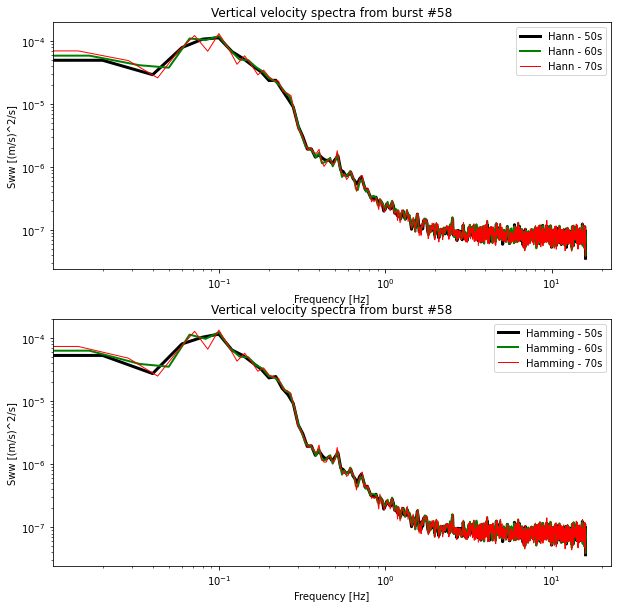

In [16]:
# Compare window types and segment lengths

# Select single "good" data burst
# Burst 76 provides a good looking spectral curve, so it will be used
# to test eps estimate parameters
burst_number = 58
ds = adv1Patch.copy(deep=True)
burst = ds.Up.where((ds.BurstNum.isin(burst_number)) & (ds.Up.isnull()==False), drop = True)

# Fedderson 2010 and 2007 uses combination of 50s and 70s windows
# Both Hann and Hamming windows used through the literature
Fw_hann50s, Sw_hann50s = welch(burst, fs=32, nperseg= 1600, window='hann') # Vertical velocity spectra
Fw_hann60s, Sw_hann60s = welch(burst, fs=32, nperseg= 1920, window='hann')
Fw_hann70s, Sw_hann70s = welch(burst, fs=32, nperseg= 2240, window='hann')

Fw_hamm50s, Sw_hamm50s = welch(burst, fs=32, nperseg= 1600, window='hamming')
Fw_hamm60s, Sw_hamm60s = welch(burst, fs=32, nperseg= 1920, window='hamming')
Fw_hamm70s, Sw_hamm70s = welch(burst, fs=32, nperseg= 2240, window='hamming')

plt.figure(figsize = (10,10))
plt.subplot(211)
plt.title('Vertical velocity spectra from burst #' + str(burst_number))
plt.loglog(Fw_hann50s, Sw_hann50s, '-k', lw = 3)
plt.loglog(Fw_hann60s, Sw_hann60s, '-g', lw = 2)
plt.loglog(Fw_hann70s, Sw_hann70s, '-r', lw = 1)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Sww [(m/s)^2/s]')
plt.legend(['Hann - 50s', 'Hann - 60s', 'Hann - 70s'])

plt.subplot(212)
plt.title('Vertical velocity spectra from burst #' + str(burst_number))
plt.loglog(Fw_hamm50s, Sw_hamm50s, '-k', lw = 3)
plt.loglog(Fw_hamm60s, Sw_hamm60s, '-g', lw = 2)
plt.loglog(Fw_hamm70s, Sw_hamm70s, '-r', lw = 1)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Sww [(m/s)^2/s]')
plt.legend(['Hamming - 50s', 'Hamming - 60s', 'Hamming - 70s'])

plt.show()

In [49]:
dof_hann50s = (8/3) * (38400/800)
dof_hann60s = (8/3) * (38400/960)
dof_hamm50s = (2.5164) * (38400/800)
dof_hamm60s = (2.5164) * (38400/960)

print(str(dof_hann50s),str(dof_hann60s),str(dof_hamm50s),str(dof_hamm60s))

128.0 106.66666666666666 120.7872 100.656


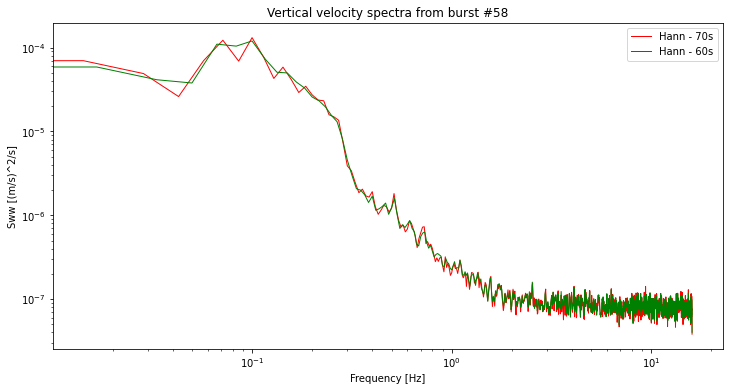

In [10]:
# Hanning window provides best dof
# 50s window smooths out alot of lower frequency wave noise, and some spectra within ISR
# 60s window provides resolution of 70s without as much chatter
# 70s yield good resolution but many spikes at higher frequencies

plt.figure(figsize = (12,6))
plt.title('Vertical velocity spectra from burst #' + str(burst_number))
plt.loglog(Fw_hann70s, Sw_hann70s, '-r', lw = 1)
plt.loglog(Fw_hann60s, Sw_hann60s, '-g', lw = 1)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Sww [(m/s)^2/s]')
plt.legend(['Hann - 70s','Hann - 60s'])

### Estimating the surface gravity wave band

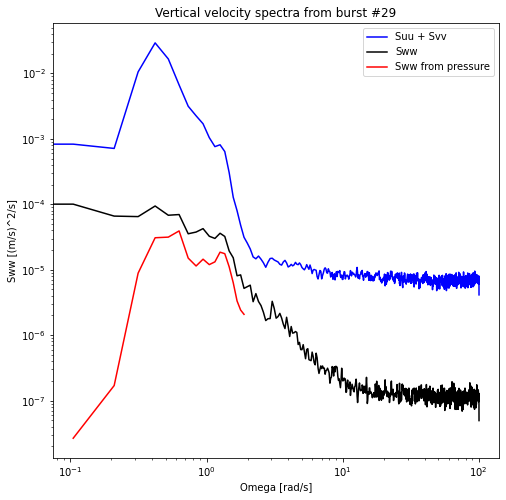

In [17]:
# A Hann window with 60s segments yields a good balance between smoothing of 50s and resolution from 70s

# First, determine the surface gravity wave band by converting pressure spectra to vertical velocity
# spectra via linear wave theory

# Good bursts = 8,29,41,42,52,55,58,59,75,76,82,90,91,106,116
burst_number = 29
ds = adv1Patch.copy(deep=True)
burstTime = ds.time.where((ds.BurstNum.isin(burst_number)) & (ds.Up.isnull()==False), drop=True)
rho = np.mean(temp.Rho.sel(depth=4,time=slice(burstTime[0],burstTime[-1]))) + 1000

vt.spectraPlotter(adv1Patch, burst_number, rho)

- Despite the pressure sensor being located at 10m of depth, converted spectra follow velocity well
- Pressure sensor noise floor causes spectra to continuously grow in spectral density, skewing results
- A hard cutoff is used at the local minimum where this noise floor begins
- Jones and Monosmith (2008) show that pressure signal falls rapidly after reaching peak energy
- However, as an extra precaution, another 1/4Hz should be added to the cutoff to be certain that the surface wave band is avoided

### Assessing Su - Sw coherence

1.074144915489242

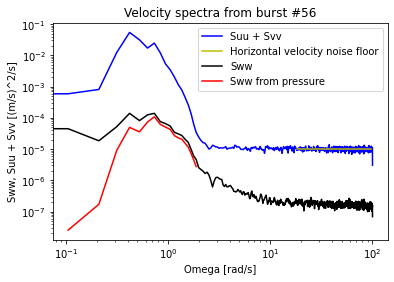

In [76]:
# Find the upper frequency cutoff at the noise floor of the instrument 
# using horizontal and vertical velocity spectra

# Test Su - Sw coherence with multiple bursts
burst_number = 56

burst = e1.where(e1.Burst_number.isin(burst_number), drop = True)

Fw, Sw = welch(burst.Vertical, fs=32, nperseg= 1920, window='hann') # Vertical velocity spectra
Fu, Su = welch(burst.U, fs=32, nperseg= 1920, window='hann') # Horiztonal velocity spectra
Fv, Sv = welch(burst.V, fs=32, nperseg= 1920, window='hann')

# Calculate and convert pressure spectra to vertical velocity to find lower cutoff frequency
pressure = burst.Pressure * 10000
Fp, Sp = welch(pressure, fs=32, nperseg= 1920, window='hann') # Pressure spectra

rho = np.mean(temp.Rho.sel(depth=4,time=slice(burst.time[0],burst.time[-1]))) + 1000
g = 9.8 # Gravity
z = pressure/(rho*g) # Depth (m): the recorded pressure converted to meters of seawater
H = np.mean(z) + .578 # Sea level height (m): mean pressure detected by the pressure sensor plus the height of sensor from the bottom
Zp = -(np.mean(z)) # Depth of pressure sensor (m)
Zv = (-H) + .824 # Depth of velocity sensor (m): Sea level height plus the height of the velocity transducers from the bottom
T = 1/Fp # Period (s^-1)

# Omega (radian frequency) and wavenumber (k)
omega,k,Cph,Cg = vt.wavedisp(T, H)

# Generate empty arrays for p' and w' values
p_prime = np.empty(len(omega))
w_prime = np.empty(len(omega))

for j in range(len(omega)): # For loops iterates over all values of omega
    p_prime[j] = (rho*g)*(np.cosh(k[j]*(Zp+H))/np.cosh(k[j]*H))
    w_prime[j] = (-omega[j])*(np.sinh(k[j]*(Zv+H)))/(np.sinh(k[j]*H))
scale_factor = w_prime**2 / p_prime**2

Sw_prime = (Sp * scale_factor)

# Determine lower cutoff frequency by identifying pressure noise floor via local minimum
lfc = argrelextrema(Sw_prime, np.less, order=10)[0][0]

# Determine higher cutoff frequency noise floor from horizontal velocity spectra
ufc = int(3.1/(np.diff(Fu)[0]))
noise = np.mean(Su[ufc:] + Sv[ufc:]) # Average all frequencies above noise floor

R_freq = Fw[lfc:ufc+1]
R_Shoriz = (Su[lfc:ufc+1]+Sv[lfc:ufc+1])-noise
R_Sw = Sw[lfc:ufc+1]

plt.figure()
plt.title('Velocity spectra from burst #' + str(burst_number))
plt.loglog(omega, Su + Sv, '-b')
plt.axhline(noise, .73, .95, color = 'y')
plt.loglog(omega, Sw, '-k')
plt.loglog(omega[0:lfc], Sw_prime[0:lfc], '-r')
plt.xlabel('Omega [rad/s]')
plt.ylabel('Sww, Suu + Svv [(m/s)^2/s]')
plt.legend(['Suu + Svv','Horizontal velocity noise floor','Sww', 'Sww from pressure'])

# The ratio R used to assesss eps reliability and isotropic turbulence
# Eq. 8 from Fedderson 2010
R_num = (12/21) * np.mean((R_freq**(5/3)) * R_Shoriz) # Numerator
R_den = np.mean((R_freq**(5/3)) * R_Sw) # Denominator
R = R_num/R_den
R

### Is horizontal velocity comparison helpful?
- For a data burst to pass UV - W coherence, R-ration must fall within .5 < R < 2
    - Most visually acceptable bursts pass this test
- Noise floor of vertical velocity spectra is consistently lower than horizontal velocity
- Wheeler and Giddings attribute this to ADV "white noise" in the horizontal direction, but not vertical
- Dissipation may be estimated using only "good-fit" vertical velocity spectra, without needing Su-Sw coherence test

# Estimating turbulent dissipation

## $\epsilon$ = ${\langle\frac{S_{ww}(\omega) \omega^\frac{5}{3}}{\alpha J_{33}(\omega)}\rangle} ^\frac{3}{2}$

- $S_{ww}(\omega)$ = Vertical velocity spectra at omega
- $\omega$ = radian frequency being evaluated
- $\alpha$ = 1.5 (Kolmogoroff's constant)
- $J_{33}(\omega)$ = integral over 3D wavenumber space that depends on the mean flow and wave-orbital velocities
- $\epsilon$ is estimated over all radian frequencies within proposed inertial subrange

### Finding the inertial subrange (ISR) and estimating eps with various methods
- Fit best power slope fit within pre-determined boundaries
- Fit -5/3 slope to set of points with and select range with smallest misfit
    - Minimum range seems to be anywhere from 1hz to 2.5hz long
- Iterative kernal density estimate used by Wheeler and Giddings

In [ ]:
#Wheeler and Giddings method is easiest since they have a dedicated function
eps1 = khf.epCalc(adv1Int,'dep1',segSize = 120, highLowSep = 1/5, turbVarCutoff = 5, waveCutoff = 1.025, unorigionalCutoff = 0.1,\
                  lowWavenumberRemoval = 2, highSpectrumRemoval = 4, binSize = 10, genScale = 1/2, minDataPoints = 10,\
                  minWavenumberSpan = 2.5, slopeConfidence = .95, peakProminence = 0.8, kdeBW=1, whiteNoiseRemove = 0, correct = True)

eps1

In [148]:
np.unique(adv1Int.BurstNum.where(adv1Int.Up.isnull()==False, drop=True), return_counts=True)

(array([  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
         14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
         25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
         47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
         58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
         69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
         80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
         91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
        102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
        113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123.,
        124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134.,
        135., 136., 137., 138., 139., 140., 141., 142., 143., 144., 145.,
        146., 147., 148., 149., 150., 

In [149]:
np.unique(adv1Patch.BurstNum.where(adv1Patch.Up.isnull()==False, drop=True), return_counts=True)

(array([  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
         14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
         25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
         47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
         58.,  59.,  60.,  61.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,
         71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,
         82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,
         93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
        104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 114.,
        115., 116., 117., 118., 119., 120., 121., 122., 123., 124., 125.,
        126., 127., 128., 129., 130., 131., 132., 133., 134., 135., 136.,
        137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147.,
        148., 149., 150., 151., 152., 

Slope test: Fail


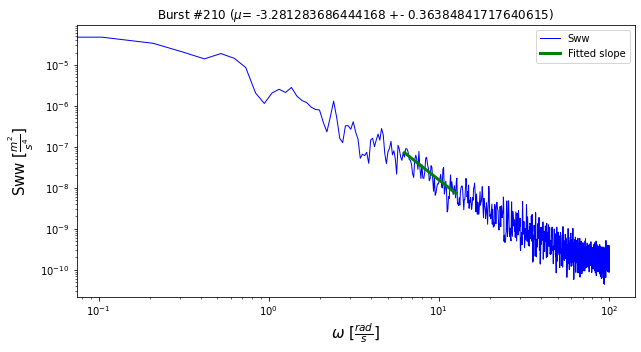

In [154]:
# Fitting to a set frequency range
# Good bursts = 8,29,41,42,52,55,58,59,75,76,82,90,91,106,116
burstNumber = 210
ds = adv1Int.copy(deep=True)

burstUp = ds.Up.where((ds.BurstNum.isin(burstNumber)) & (ds.Up.isnull()==False), drop = True)

Fw, Sw = welch(burstUp, fs=32, nperseg= 1920, window='hann') # Vertical velocity spectra

lfc = np.where(Fw == 1)[0][0]
ufc = np.where(Fw == 2)[0][0]

T = 1/Fw
H = np.mean(ds.Depth)
omega,k,Cph,Cg = vt.wavedisp(T, H)

try:
    #Fit a power_curve to each combination of bounds
    pars, cov = curve_fit(f=vt.power_law, xdata=omega[lfc:ufc+1],
                          ydata=Sw[lfc:ufc+1], p0=[0, 0], bounds=(-np.inf, np.inf), maxfev=10000)
            
    Int = pars[0] #Fit intercept
    IntErr = np.sqrt(np.diag(cov))[0] #intercept error
    Mu = pars[1] #Fit slope
    MuErr = np.sqrt(np.diag(cov))[1] #Slope error
except RuntimeError:
    pass

muFit =  Int*(omega[lfc:ufc+1]**Mu)
lowMu = Mu - (2*MuErr) - .06
highMu = Mu + (2*MuErr) + .06

if (lowMu < (-5/3)) & (highMu > (-5/3)):
    print('Slope test: Pass')
else:
    print('Slope test: Fail')

plt.figure(figsize = (10,5))
plt.title('Burst #'+str(burstNumber)+ ' ($\mu$= '+str(Mu)
          +' +- '+str(MuErr)+')')
plt.loglog(omega, Sw, '-b', lw = 1)
plt.loglog(omega[lfc:ufc+1], muFit, '-g', lw = 3)
plt.xlabel(r'$\omega$ $[\frac{rad}{s}]$', fontsize = 15)
plt.ylabel(r'Sww $[\frac{m^{2}}{s^{4}}]$', fontsize = 15)
plt.legend(['Sww','Fitted slope'], loc = 'upper right')

In [126]:
burst_number = np.unique(e1.Burst_number)

isrInt = np.empty_like(burst_number)
isrIntErr = np.empty_like(burst_number)
isrMu = np.empty_like(burst_number)
isrMuErr = np.empty_like(burst_number)
isrBounds = np.empty((len(burst_number),2))
fullSw = np.empty((len(burst_number),len(omega)))
fullSu = np.empty((len(burst_number),len(omega)))
fullSv = np.empty((len(burst_number),len(omega)))
Rtest = np.empty_like(burst_number)
noise = np.empty_like(burst_number)

for b in enumerate(burst_number):
    burst = e1.where(e1.Burst_number.isin(b[1]), drop = True)
    #print('Calculating U,V, and W spectra')
    # Generate vertical and horizontal velocity spectra
    Fw, Sw = welch(burst.Vertical, fs=32, nperseg= 1920, window='hann') # Vertical velocity spectra
    Fu, Su = welch(burst.U, fs=32, nperseg= 1920, window='hann') # Horiztonal velocity spectra
    Fv, Sv = welch(burst.V, fs=32, nperseg= 1920, window='hann')

    #print('Converting pressure spectra to vertical velocity')
    # Calculate and convert pressure spectra to vertical velocity to find lower cutoff frequency
    pressure = burst.Pressure * 10000
    Fp, Sp = welch(pressure, fs=32, nperseg= 1920, window='hann') # Pressure spectra

    rho = np.mean(temp.Rho.sel(depth=slice(4,7),time=slice(burst.time[0],burst.time[-1]))) + 1000
    g = 9.8 # Gravity
    z = pressure/(rho*g) # Depth (m): the recorded pressure converted to meters of seawater
    H = np.mean(z) + .578 # Sea level height (m): mean pressure detected by the pressure sensor plus the height of sensor from the bottom
    Zp = -(np.mean(z)) # Depth of pressure sensor (m)
    Zv = (-H) + .824 # Depth of velocity sensor (m): Sea level height plus the height of the velocity transducers from the bottom
    T = 1/Fp # Period (s^-1)

    # Omega (radian frequency) and wavenumber (k)
    omega,k,Cph,Cg = vt.wavedisp(T, H)

    # Generate empty arrays for p' and w' values
    p_prime = np.empty(len(omega))
    w_prime = np.empty(len(omega))

    for j in range(len(omega)): # For loop iterates over all values of omega
        p_prime[j] = (rho*g)*(np.cosh(k[j]*(Zp+H))/np.cosh(k[j]*H))
        w_prime[j] = (-omega[j])*(np.sinh(k[j]*(Zv+H)))/(np.sinh(k[j]*H))
    scaleFactor = w_prime**2 / p_prime**2
    
    #Calculate the equivalent Sw spectra from Sp
    Sw_prime = (Sp * scaleFactor)

    #print('Finding cutoff frequencies')
    #Define the lower cutoff frequency as the end of surface gravity wave band
    try:
        waveCutoff = argrelextrema(Sw_prime, np.less, order=10)[0][0]
    except IndexError:
        waveCutoff = 20
    # add 1/8hz to wave cutoff to account for pressure noise floor before pressure spectrum falls off
    lfc = int(waveCutoff + ((np.pi/4)/np.diff(omega)[0])) 

    #Define the upper cutoff frequency as the beginning of the noise floor
    noiseFloorFreq = np.where(omega > (6.1*np.pi))[0][0] #Typically occurs > 6pi
    noiseFloorMag = np.mean(Sw[noiseFloorFreq:]) #Calculate mean of noise spectrum
    ufc = np.where(Sw < noiseFloorMag)[0][0] #Define ufc as final point below the noise floor

    #print('Estimating inertial subrange boundaries')
    #### Self optimizing inertial subrange finder ####
    
    #Generate list of every possible boundary combination within lower and upper cutoff frequencies
    #ISR should be at least 1hz in length (which is forgiving compared to 2.5hz in Gerbi et al.)

    isrGap = int(((2*np.pi)/np.diff(omega)[0]))
    totalRange = np.arange(lfc, ufc)
    bounds = []

    if (ufc-lfc) <= isrGap:
        # If the range is shorter than 1hz, rangefinder fits between the two cutoffs
        iteratorRange = np.arange(lfc+2, ufc) #offset by +2 since scipy_curve fit needs more than two datapoints
        for i in range(ufc-(lfc+2)):
            for j in range(len(iteratorRange)):
                bounds.append((totalRange[i], iteratorRange[j]))
            iteratorRange = iteratorRange[1:ufc] #Each iteration shortens iterator range by 1 to prevent repeat and backwards combinations
    
    else:
        iteratorRange = np.arange(lfc+isrGap, ufc) #1hz gap applied to the rangefinder
        for i in range(ufc-(lfc+isrGap)):
            for j in range(len(iteratorRange)):
                bounds.append((totalRange[i], iteratorRange[j]))
            iteratorRange = iteratorRange[1:ufc] #Each iteration shortens iterator range by 1 to prevent repeat and backwards combinations

    #Generate arrays for parameters of curve_fit for future evaluation
    intercepts = np.empty(len(bounds))
    intErr = np.empty(len(bounds))
    exponents = np.empty(len(bounds))
    expErr = np.empty(len(bounds))
    rangeLen = np.empty(len(bounds))

    for i in range(len(bounds)):
        try:
            #Fit a power_curve to each combination of bounds
            pars, cov = curve_fit(f=vt.power_law, xdata=omega[bounds[i][0]:bounds[i][1]],
                                     ydata=Sw[bounds[i][0]:bounds[i][1]], p0=[0, 0], bounds=(-np.inf, np.inf), maxfev=10000)
            
            intercepts[i] = pars[0] #Fit intercept
            intErr[i] = np.sqrt(np.diag(cov))[0] #intercept error
            exponents[i] = pars[1] #Fit slope
            expErr[i] = np.sqrt(np.diag(cov))[1] #Slope error
            rangeLen[i] = bounds[i][1]-bounds[i][0] #Boundaries of the current fit
        #Boundaries may be poor fits and will exceed 'maxfev' of curve_fit function, causing a runtime error
        #This ensures the loop continues
        except RuntimeError:
            intercepts[i] = 99999
            intErr[i] = 99999
            exponents[i] = 99999
            expErr[i] = 99999
            rangeLen[i] = bounds[i][1]-bounds[i][0]

    #Extra precaution to ensure nan values are removed
    #nan_to_num gets rid of nan values and replaces them with 0's to prevent errors later on
    exponents = np.nan_to_num(exponents, nan=99999)
    expErr = np.nan_to_num(expErr, nan=99999)
    intercepts = np.nan_to_num(intercepts, nan=99999)
    intErr = np.nan_to_num(intErr, nan=99999)

    #Find how close each boundary combination is to ideal -5/3 slope
    muDiff = np.abs((-5/3) - exponents)

    #Define metric for finding the most ideal boundary combination
    #Having an isr with a good slope, low error, and bigger range yields better ratio
    #isr_ratio = (range_lengths**2)/(mu_diff*exp_errors)
    isrRatio = 1/(muDiff*expErr)
    isrRatio = np.nan_to_num(isrRatio, nan=0)
    
    #Define the isr as the fit with the highest ratio
    isrRange = np.where(isrRatio == np.max(isrRatio))[0][0]

    #Define the new lower and upper bounds of the isr
    isr_lb = bounds[isrRange][0]
    isr_ub = bounds[isrRange][1]

    #print('Computing ratio R')
    # Find the Sw - Suv coherence ratio R
    Rnoise = np.mean(Su[ufc:] + Sv[ufc:]) # Average all frequencies above horizontal noise floor 
    R_freq = Fw[isr_lb:isr_ub+1]
    R_Suv = (Su[isr_lb:isr_ub+1]+Sv[isr_lb:isr_ub+1])-Rnoise
    R_Sw = Sw[isr_lb:isr_ub+1]
    R_numerator = (12/21) * np.mean((R_freq**(5/3)) * R_Suv) # Numerator
    R_denominator = np.mean((R_freq**(5/3)) * R_Sw) # Denominator
    R = R_numerator/R_denominator # Eq. 8 from Fedderson 2010
    
    isrInt[b[0]] = intercepts[isrRange]
    isrIntErr[b[0]] = intErr[isrRange]
    isrMu[b[0]] = exponents[isrRange]
    isrMuErr[b[0]] = expErr[isrRange]
    isrBounds[b[0]] = bounds[isrRange]
    fullSw[b[0]] = Sw
    fullSu[b[0]] = Su
    fullSv[b[0]] = Sv
    Rtest[b[0]] = R
    noise[b[0]] = noiseFloorMag
   
    print(b[0])

isrBounds = isrBounds.astype(int)
fullOmega = omega
fullFreq = Fw

NameError: name 'e1' is not defined

In [ ]:
# Vertical wavenumber space integral from Gerbi et al. (2009)
J_ll = pd.read_csv('ADV/J_ll.csv') # Previously made dataset from "Wavenumber_integral.ipynb"
J_ll = J_ll.rename(columns={"Unnamed: 0": "Burst_number"})
J_33 = J_ll.J_33

In [638]:
# Estimates dissipation from the previously estimated isr
J33 = np.empty_like(burst_number) # Wavenumber space integral
epsMag = np.empty_like(burst_number) # Mean of eps values over isr
epsFitInt = np.empty_like(burst_number) # Intercept of eps estimate linear regression model
epsFitSlope = np.empty_like(burst_number) # Slope
epsFitR2val = np.empty_like(burst_number) # R2-value
epsFitPval = np.empty_like(burst_number) # P-value

alpha = 1.5 # Kolomogorov constant

for i in range(len(burst_number)):
    Omega = fullOmega[isrBounds[i][0]:isrBounds[i][1]]
    S_33 = fullSw[i][isrBounds[i][0]:isrBounds[i][1]]
    eps = ((S_33 * (Omega**(5/3)))/(alpha * J_33[i]))**(3/2)
    
    res = stats.linregress(Omega, eps)
    
    J33[i] = J_33[i]
    epsMag[i] = np.mean(eps)
    epsFitInt[i] = res.intercept
    epsFitSlope[i] = res.slope
    epsFitR2val[i] = res.rvalue**2
    epsFitPval[i] = res.pvalue

In [647]:
# Create a new dataset with all relevant variables and epsilon values
ds1 = xr.Dataset(
        data_vars=dict(
            Suu = (["bNum","omega"], fullSu),
            Svv = (["bNum","omega"], fullSv),
            Sww = (["bNum","omega"], fullSw),
            J33 = (["bNum"], J33),
            isrBounds = (["bNum","bounds"], isrBounds),
            isrInt = (["bNum"], isrInt),
            isrIntErr = (["bNum"], isrIntErr),
            isrMu = (["bNum"], isrMu),
            isrMuErr = (["bNum"], isrMuErr),
            epsMag = (["bNum"], epsMag),
            R_ratio = (["bNum"], Rtest),
            Noisefloor = (["bNum"], noise),
            epsFitInt = (["bNum"], epsFitInt),
            epsFitSlope = (["bNum"], epsFitSlope),
            epsFitR2val = (["bNum"], epsFitR2val),
            epsFitPval = (["bNum"], epsFitPval),
                
        ),
        coords=dict(
            bNum=(["bNum"], burst_number),
            omega=(["omega"], omega_total[0]),
            frequency=(["frequency"], freq_total[0]),
            bounds=(["bounds"], ['lower','upper'])
        ),
        attrs=dict(description="All data from estimated turbulent dissipation"),
    )

In [640]:
eps_ds1

<xarray.Dataset>
Dimensions:      (bNum: 135, bounds: 2, frequency: 961, omega: 961)
Coordinates:
  * bNum         (bNum) float64 3.0 4.0 5.0 6.0 7.0 ... 190.0 205.0 218.0 219.0
  * omega        (omega) float64 0.0 0.1047 0.2094 0.3142 ... 100.3 100.4 100.5
  * frequency    (frequency) float64 0.0 0.01667 0.03333 ... 15.97 15.98 16.0
  * bounds       (bounds) <U5 'lower' 'upper'
Data variables:
    Suu          (bNum, omega) float64 0.0002181 0.0003045 ... 4.005e-05
    Svv          (bNum, omega) float64 3.388e-05 9.974e-05 ... 2.566e-05
    Sww          (bNum, omega) float64 5.406e-06 2.92e-05 ... 3.277e-06
    J33          (bNum) float64 0.0287 0.02947 0.02829 ... 0.02124 0.05473
    isrBounds    (bNum, bounds) int32 27 92 26 137 28 189 ... 239 58 122 30 147
    isrInt       (bNum) float64 6.928e-06 3.934e-06 ... 2.12e-05 0.0118
    isrIntErr    (bNum) float64 7.22e-07 2.438e-07 ... 8.993e-06 0.001315
    isrMu        (bNum) float64 -1.667 -1.083 -0.6613 ... -0.3608 -1.667 -1.667
    isrMuErr     (bNum) float64 0.07401 0.03813 0.02845 ... 0.2045 0.07163
    epsMag       (bNum) float64 2.28e-06 6.025e-06 ... 1.854e-05 0.04222
    R_ratio      (bNum) float64 1.95 2.029 1.815 1.57 ... 5.395 5.452 7.552 1.72
    Noisefloor   (bNum) float64 1.219e-07 1.929e-07 ... 2.658e-07 1.094e-05
    epsFitInt    (bNum) float64 9.071e-07 -1.051e-06 ... 7.307e-06 0.08957
    epsFitSlope  (bNum) float64 2.221e-07 8.342e-07 ... 1.199e-06 -0.005137
    epsFitR2val  (bNum) float64 0.2489 0.7552 0.8386 ... 0.8718 0.09274 0.4836
    epsFitPval   (bNum) float64 2.334e-05 4.314e-35 ... 0.01442 3.322e-18
Attributes:
    description:  All data from estimated turbulent dissipation

### Quality controlling the epsilon estimates
- To accept an estimate of epsilon:
    - isrInt (intercept) > isrIntErr (error in the intercept) (Jones and Monosmith 2008)
    - Noise is < half the magnitude of spectrum at minimum frequency (omega_min) (Gerbi et al. 2009)
    - Slope fit and slope error fall within acceptable boundaries (Feddersen 2010)
        - (mu - 2mu_err - .06 < -5/3 < mu + 2mu_err + .06)
    - Linear regression of eps estimates within isr has a slope that is statistically indistinguishable from 0 Feddersen 2010
        - scipy.linregress p-value indicates test where the H0 is that slope is 0
        - Therefore, we want to accept the null hypothesis
        - If p-value > .05, we can't reject the null that the slope is indistinguishable from 0
    - R ratio near unity (.5 < R < 2) Feddersen 2010


In [838]:
epsFlag = xr.zeros_like(ds1.bNum)

# Isr fit intercept test
epsFlag = epsFlag + xr.where((ds1.isrInt > ds1.isrIntErr), 0, 1) 

# Minimum isr spectrum greater than noise floor test
isrUpperBounds = ds1.isrBounds.where(ds1.bounds == 'lower', drop=True)
isrUpperBounds = xr.concat(test.astype(int), dim="bounds")
isrSwMin = np.empty_like(ds.bNum)
for i in range(len(ds1.bNum)):
    isrSwMin[i] = ds1.Sww[i][isrUpperBounds[i]].values
    
epsFlag = epsFlag + xr.where(isrSwMin > (ds1.Noisefloor/2), 0, 1)

# Isr slope test
lowMu = ds1.isrMu - (2*ds1.isrMuErr) - .06
highMu = ds1.isrMu + (2*ds1.isrMuErr) + .06

epsFlag = epsFlag + xr.where((lowMu < (-5/3)) & (highMu > (-5/3)), 0, 1)

# eps estimate linear regression test
epsFlag = epsFlag + xr.where(ds1.epsFitPval > .05, 0, 1)

# Sww - Suv unity test
#epsFlag = epsFlag + xr.where((ds1.R_ratio >.5) & (ds1.R_ratio <2), 0, 1)

In [839]:
epsFlag

<xarray.DataArray (bNum: 135)>
array([1., 2., 2., 1., 2., 0., 1., 0., 1., 1., 2., 1., 1., 2., 2., 0., 2.,
       2., 1., 0., 0., 2., 2., 2., 2., 2., 0., 1., 0., 0., 2., 1., 1., 2.,
       1., 2., 2., 2., 0., 0., 0., 2., 1., 2., 1., 2., 1., 1., 2., 0., 1.,
       1., 0., 1., 1., 0., 0., 2., 1., 1., 2., 2., 1., 1., 1., 1., 2., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 2., 1., 2., 1., 2., 2., 0., 0., 2.,
       2., 0., 0., 0., 0., 1., 2., 1., 2., 0., 1., 1., 2., 0., 0., 2., 2.,
       2., 0., 2., 2., 2., 2., 0., 1., 2., 2., 2., 1., 0., 2., 2., 2., 2.,
       1., 2., 2., 2., 2., 1., 1., 2., 1., 2., 0., 2., 2., 2., 1., 1.])
Coordinates:
  * bNum     (bNum) float64 3.0 4.0 5.0 6.0 7.0 ... 190.0 205.0 218.0 219.0

In [840]:
goodBursts = ds1.bNum.where(epsFlag == 0,drop=True).values
gb = ds1.where(ds1.bNum.isin(goodBursts), drop=True)
Sww = gb.Sww.values
omega = gb.omega.values
J_33 = gb.J33.values
isrBounds = gb.isrBounds.values.astype(int)
isrInt = gb.isrInt.values
isrMu = gb.isrMu.values
isrMuErr = gb.isrMuErr.values
epsMag = gb.epsMag.values
epsFitInt = gb.epsFitInt.values
epsFitSlope = gb.epsFitSlope.values

In [841]:
gb.bNum

<xarray.DataArray 'bNum' (bNum: 34)>
array([  8.,  10.,  18.,  22.,  23.,  29.,  31.,  32.,  41.,  42.,  43.,  52.,
        55.,  58.,  59.,  75.,  76.,  79.,  80.,  81.,  82.,  90.,  91.,  94.,
        95.,  96.,  97., 102., 106., 107., 111., 116., 124., 187.])
Coordinates:
  * bNum     (bNum) float64 8.0 10.0 18.0 22.0 23.0 ... 111.0 116.0 124.0 187.0

In [ ]:
# Good bursts = 8,29,41,42,52,55,58,59,75,76,82,90,91,106,116

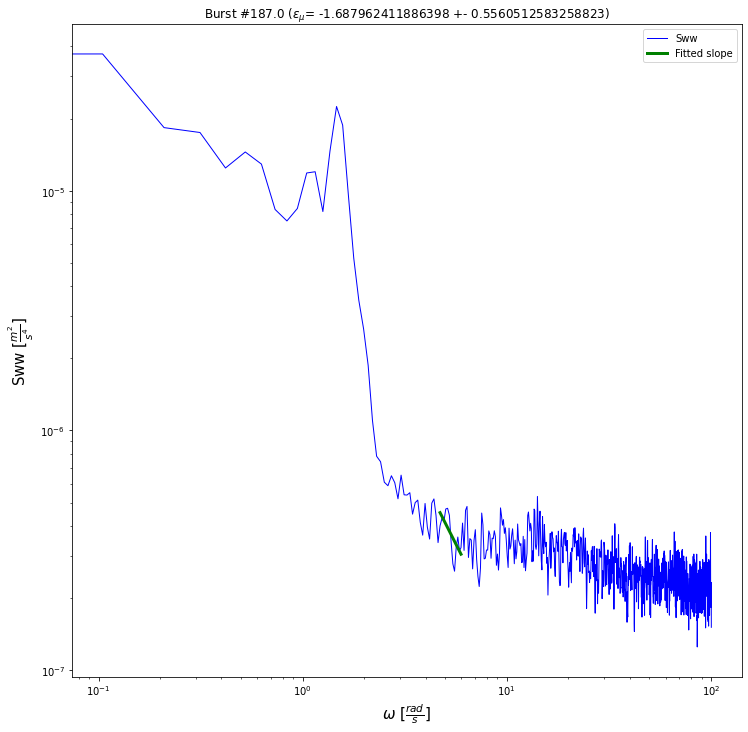

In [870]:
i = 33
radFreq = omega[isrBounds[i][0]:isrBounds[i][1]]

muFit =  isrInt[i]*(radFreq**isrMu[i])

alpha = 1.5 # Kolomogorov constant
S_33 = Sww[i][isrBounds[i][0]:isrBounds[i][1]]
eps = ((S_33 * (radFreq**(5/3)))/(alpha * J_33[i]))**(3/2)

epsFit = epsFitInt[i] * (radFreq*epsFitSlope[i])

plt.figure(figsize = (12,12))
#plt.subplot(211)
plt.title('Burst #'+str(gb.bNum[i].values)+ r' ($\epsilon_\mu$= '+str(isrMu[i])
          +' +- '+str(isrMuErr[i])+')')
plt.loglog(omega, Sww[i], '-b', lw = 1)
plt.loglog(radFreq, muFit, '-g', lw = 3)
plt.xlabel(r'$\omega$ $[\frac{rad}{s}]$', fontsize = 15)
plt.ylabel(r'Sww $[\frac{m^{2}}{s^{4}}]$', fontsize = 15)
plt.legend(['Sww','Fitted slope'], loc = 'upper right')

#plt.subplot(212)
#plt.title(r'$\epsilon(f)$: '+str(eps_mean[i])+' +-'+str(stats.sem(eps_range[i])))
#plt.plot(Omega_list[i], eps_range[i], '-k')
#plt.axhline(eps_mean[i], c = 'blue', ls = '-')
#plt.plot(Omega_list[i], res_list[i].intercept + res_list[i].slope*Omega_list[i], '--r')
#plt.xlabel(r'$\omega$ $[\frac{rad}{s}]$', fontsize = 15)
#plt.ylabel(r'$\epsilon$ $[\frac{m^{2}}{s^{3}}]$', fontsize = 15)
#res_list[i]